In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchsummary import summary
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, roc_curve, auc, average_precision_score, precision_recall_curve
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import label_binarize
import torch.optim as optim

In [2]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Set paths for dataset splits
train_dir = 'I:/RICE/final_rice_data/train'
val_dir = 'I:/RICE/final_rice_data/val'
test_dir = 'I:/RICE/final_rice_data/test'

In [4]:
# Function to count images in a directory
def count_images_in_directory(directory):
    count = 0
    for _, _, files in os.walk(directory):
        count += len([f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    return count

# Count images in each directory
train_count = count_images_in_directory(train_dir)
val_count = count_images_in_directory(val_dir)
test_count = count_images_in_directory(test_dir)

# Display the counts
print(f"Total number of images in the training set: {train_count}")
print(f"Total number of images in the validation set: {val_count}")
print(f"Total number of images in the test set: {test_count}")

Total number of images in the training set: 10000
Total number of images in the validation set: 1250
Total number of images in the test set: 1250


In [8]:
# Data augmentation and normalization for training
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),          # Resize images
    transforms.RandomHorizontalFlip(),        # Random horizontal flip
    transforms.RandomRotation(20),            # Random rotation
    transforms.ToTensor(),                    # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalize
])

In [9]:
# Normalization for validation and test
val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [10]:
# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_test_transforms)
test_dataset = datasets.ImageFolder(root=test_dir, transform=val_test_transforms)

In [11]:
# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [12]:
# Define the MobileNetV2 model architecture
class MobileNetV2Model(nn.Module):
    def __init__(self, num_classes):
        super(MobileNetV2Model, self).__init__()
        self.mobilenet = models.mobilenet_v2(pretrained=True)  # Load MobileNetV2 with pretrained weights
        self.mobilenet.classifier[1] = nn.Linear(self.mobilenet.classifier[1].in_features, num_classes)  # Modify classifier

    def forward(self, x):
        return self.mobilenet(x)

# Initialize the model
num_classes = 5  # Adjust based on your dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MobileNetV2Model(num_classes).to(device)

C:\Users\Administrator\anaconda3\envs\torch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Administrator\anaconda3\envs\torch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
# Display model summary
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [14]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [15]:
# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader, desc='Training', leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

In [16]:
# Validation function
def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    accuracy = 100 * correct / total
    return avg_val_loss, accuracy

In [17]:
# Define a function to train and validate the model with early stopping
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, patience=5):
    # Store losses and accuracies
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    best_val_accuracy = 0
    epochs_without_improvement = 0
    
    for epoch in range(num_epochs):
        # Train the model
        train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
        # Validate the model
        val_loss, val_accuracy = validate(model, val_loader, criterion, device)

        # Append to lists for plotting later
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Print training and validation results
        print(f"Epoch {epoch + 1}/{num_epochs} - "
              f"Training Accuracy: {train_accuracy:.4f} - "
              f"Training Loss: {train_loss:.4f} - "
              f"Validation Accuracy: {val_accuracy:.4f} - "
              f"Validation Loss: {val_loss:.4f}")

        # Check if we have a new best validation accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            epochs_without_improvement = 0
            # Save the best model state
            torch.save(model.state_dict(), 'best_crack_detection_model.pth')
            print(f"Best model saved with accuracy: {best_val_accuracy:.4f}%")
        else:
            epochs_without_improvement += 1
        
        # Check for early stopping
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered. Stopping training at epoch {epoch + 1}.")
            break

    return train_losses, val_losses, val_accuracies

In [18]:
# Train and evaluate the model
num_epochs = 20
train_losses, val_losses, val_accuracies = train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

Epoch 1/20 - Training Accuracy: 72.4300 - Training Loss: 0.8120 - Validation Accuracy: 88.4800 - Validation Loss: 0.3887
Best model saved with accuracy: 88.4800%


Epoch 2/20 - Training Accuracy: 89.8000 - Training Loss: 0.3139 - Validation Accuracy: 93.4400 - Validation Loss: 0.2129
Best model saved with accuracy: 93.4400%


Epoch 3/20 - Training Accuracy: 93.2400 - Training Loss: 0.2052 - Validation Accuracy: 94.3200 - Validation Loss: 0.1543
Best model saved with accuracy: 94.3200%


Epoch 4/20 - Training Accuracy: 94.8500 - Training Loss: 0.1511 - Validation Accuracy: 95.6000 - Validation Loss: 0.1247
Best model saved with accuracy: 95.6000%


Epoch 5/20 - Training Accuracy: 95.0000 - Training Loss: 0.1378 - Validation Accuracy: 96.3200 - Validation Loss: 0.1132
Best model saved with accuracy: 96.3200%


Epoch 6/20 - Training Accuracy: 95.8100 - Training Loss: 0.1203 - Validation Accuracy: 97.0400 - Validation Loss: 0.0847
Best model saved with accuracy: 97.0400%


Epoch 7/20 - Training Accuracy: 95.8800 - Training Loss: 0.1145 - Validation Accuracy: 97.2000 - Validation Loss: 0.0742
Best model saved with accuracy: 97.2000%


Epoch 8/20 - Training Accuracy: 96.7800 - Training Loss: 0.0931 - Validation Accuracy: 97.4400 - Validation Loss: 0.0665
Best model saved with accuracy: 97.4400%


Epoch 9/20 - Training Accuracy: 96.7500 - Training Loss: 0.0876 - Validation Accuracy: 97.6000 - Validation Loss: 0.0749
Best model saved with accuracy: 97.6000%


Epoch 10/20 - Training Accuracy: 97.1500 - Training Loss: 0.0816 - Validation Accuracy: 97.6800 - Validation Loss: 0.0604
Best model saved with accuracy: 97.6800%


Epoch 11/20 - Training Accuracy: 97.2300 - Training Loss: 0.0828 - Validation Accuracy: 97.6800 - Validation Loss: 0.0588


Epoch 12/20 - Training Accuracy: 97.4500 - Training Loss: 0.0728 - Validation Accuracy: 97.8400 - Validation Loss: 0.0506
Best model saved with accuracy: 97.8400%


Epoch 13/20 - Training Accuracy: 97.5700 - Training Loss: 0.0712 - Validation Accuracy: 98.2400 - Validation Loss: 0.0487
Best model saved with accuracy: 98.2400%


Epoch 14/20 - Training Accuracy: 97.8300 - Training Loss: 0.0637 - Validation Accuracy: 98.1600 - Validation Loss: 0.0465


Epoch 15/20 - Training Accuracy: 97.9400 - Training Loss: 0.0610 - Validation Accuracy: 98.4800 - Validation Loss: 0.0506
Best model saved with accuracy: 98.4800%


Epoch 16/20 - Training Accuracy: 97.9000 - Training Loss: 0.0594 - Validation Accuracy: 98.4800 - Validation Loss: 0.0475


Epoch 17/20 - Training Accuracy: 97.9500 - Training Loss: 0.0569 - Validation Accuracy: 98.5600 - Validation Loss: 0.0467
Best model saved with accuracy: 98.5600%


Epoch 18/20 - Training Accuracy: 98.1600 - Training Loss: 0.0555 - Validation Accuracy: 98.0800 - Validation Loss: 0.0423


Epoch 19/20 - Training Accuracy: 98.2300 - Training Loss: 0.0503 - Validation Accuracy: 98.3200 - Validation Loss: 0.0404


Epoch 20/20 - Training Accuracy: 98.2800 - Training Loss: 0.0490 - Validation Accuracy: 98.7200 - Validation Loss: 0.0377
Best model saved with accuracy: 98.7200%


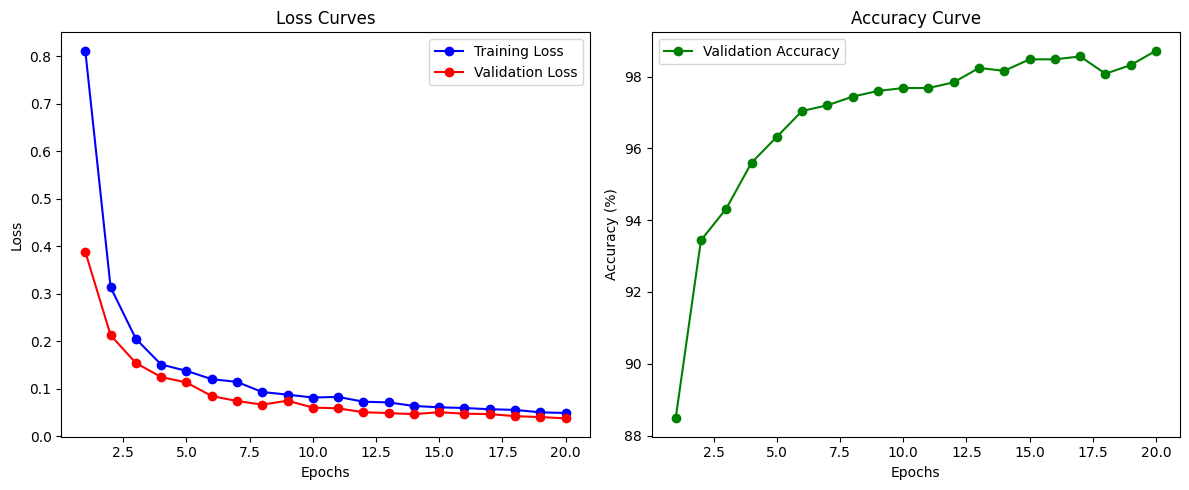

In [20]:
# Plotting accuracy and loss curves
def plot_curves(train_losses, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 5))

    # Plot Loss Curves
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy Curves
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, 'go-', label='Validation Accuracy')
    # plt.plot(epochs, train_accuracies, 'go-', label='Train Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot the curves
plot_curves(train_losses, val_losses, val_accuracies)